Route 1: [0, 20, 21, 47, 0]
Truck capacity: 40.0
Total distance travelled: 47.027756377319946
Total time: 1162.02775637732

Route 2: [0, 22, 49, 0]
Truck capacity: 30.0
Total distance travelled: 48.37489777289498
Total time: 1110.2093727122985

Route 3: [0, 67, 65, 63, 62, 66, 69, 75, 0]
Truck capacity: 130.0
Total distance travelled: 71.0179439165756
Total time: 1143.8113883008418

Route 4: [0, 23, 52, 0]
Truck capacity: 20.0
Total distance travelled: 54.43695185175311
Total time: 1023.2132034355964

Route 5: [0, 24, 25, 27, 28, 26, 34, 50, 0]
Truck capacity: 120.0
Total distance travelled: 88.73019473647331
Total time: 976.0071118131573

Route 6: [0, 5, 3, 4, 1, 0]
Truck capacity: 40.0
Total distance travelled: 39.814287642690964
Total time: 1020.6815416922694

Route 7: [0, 7, 8, 9, 6, 2, 0]
Truck capacity: 100.0
Total distance travelled: 48.779042743927064
Total time: 935.6155281280883

Route 8: [0, 43, 42, 41, 40, 44, 45, 48, 51, 91, 0]
Truck capacity: 100.0
Total distance travelle

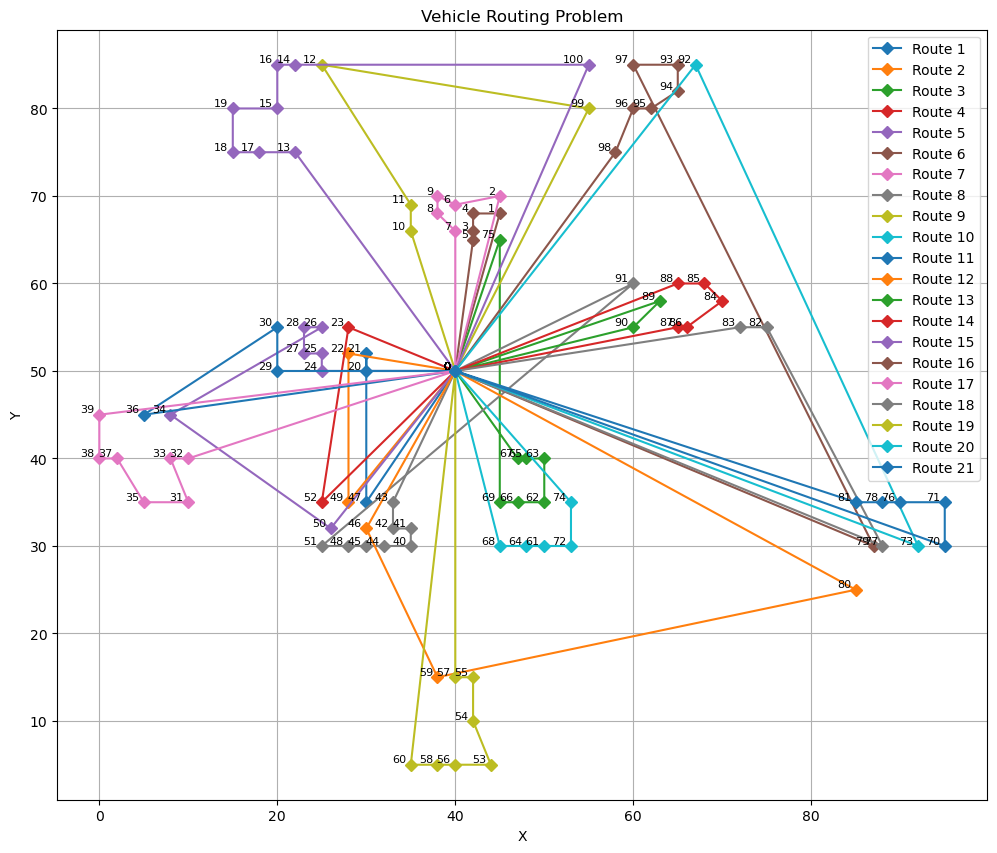

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_excel_file(file_path, sheet_name):
    """
    Read coordinates and demand values from a specific sheet in an Excel file.
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    coordinates = df[['X', 'Y']].values
    demands = df['Demand'].values
    return coordinates, demands

def read_txt_file(file_path):
    """
    Reads a VRP text file and extracts vehicle and customer information.
    """
    with open(file_path, 'r') as file:      # Read data
        lines = file.readlines()            # Split data into line
    vehicle_info = lines[4].split()         # Informations about vehicles are on line 5 for Solomon instance (index 4)
    vehicle_number = vehicle_info[0]        # Number of vehicle available
    vehicle_capacity = vehicle_info[1]      # Maximun capacity allowed in vehicle
    customer_data_start = lines.index("CUSTOMER\n") + 3  # Informations about customers start 3 lines after the index of the word "CUSTOMER"
    customer_lines = lines[customer_data_start:]
    
    coordinates = []
    demands = []
    ready_times = []
    due_times = []
    service_times = []
    
    for line in customer_lines:
        if line.strip():  # Skip empty lines
            values = list(map(float, line.split()))
            coordinates.append((values[1], values[2]))  # (X, Y)
            demands.append(values[3])  # Demand
            ready_times.append(values[4])  # Ready Time
            due_times.append(values[5])  # Due Date
            service_times.append(values[6])  # Service Time
    
    return vehicle_number, vehicle_capacity, coordinates, demands, ready_times, due_times, service_times
   
def adjacency_matrix(coordinates):
    """
    Calculate the adjacency matrix.
    """
    num_points = len(coordinates)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            adj_matrix[i, j] = calculate_distance(coordinates, i, j)
    return adj_matrix

def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calculate_total_distance(route, adj_matrix):
    """
    Calculate the total distance of a given route using the distance matrix.
    """
    total_distance = 0
    num_points = len(route)
    for i in range(num_points - 1):
        current_node = route[i]
        next_node = route[i + 1]
        total_distance += adj_matrix[current_node, next_node]
    return total_distance

def nearest_neighbor_with_time_windows(adj_matrix, demands, capacity_max, earliest_time, latest_time, service_time):
    """
    Nearest Neighbor heuristic with time windows.
    """
    num_points = adj_matrix.shape[0]                    # Count rows in matrix to get the number of point
    visited = [False] * num_points                      # Boolean array to inform if a point was visited or not
    routes = []                                         # Array including multiple routes
    capacity_list = []                                  # Array stocking final capacity of each route
    time_list = []                                      # Array keeping total time needed for each route in mind

    while sum(visited) < num_points:                    # While all point are not visited
        current_node = 0                                # Start at the depot
        current_capacity = 0                            # Initialize empty capacity
        current_time = earliest_time[current_node]      # Initialize current_time to the READY TIME of the depot (often 0)
        route = [current_node]                          # Array stocking the current route starting with the depot (current_node = 0)
        visited[current_node] = True                    # Current node is now visited

        while True:
            last_node = route[-1]                       # last_node is the last element in route
            nearest = None                              # nearest correspond to the next nearest neighbor (which is unknown here)
            min_distance = float('inf')                 # min_distance must be initialized with the max value possible to not bias the results

            for neighbor in [i for i, v in enumerate(visited) if not v]:
                travel_time = adj_matrix[last_node, neighbor]                   # We suppose time = distance (1 unit of distance take 1 unit of time)
                arrival_time = current_time + travel_time                

                if (demands[neighbor] + current_capacity <= capacity_max        # If the truck capacity is not higher than the capacity max
                        and arrival_time <= latest_time[neighbor]               # and if the arrival_time is not higher than the LATEST TIME of the neighbor
                        and adj_matrix[last_node, neighbor] < min_distance):    # and if the distance betweeen last node and a neighbor is lower than min ditance 
                    nearest = neighbor                                   
                    min_distance = adj_matrix[last_node, neighbor]              # We change the value of the nearest node and min_distance

            # If we dont find any other neighbor, we stop the route
            if nearest is None:                         
                break

            # Update route, time, and capacity
            travel_time = adj_matrix[last_node, nearest]
            current_time += travel_time
            current_time = max(current_time, earliest_time[nearest])  # Wait if arriving early
            current_time += service_time[nearest]  # Add service time
            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

        # Return to depot
        travel_time = adj_matrix[route[-1], 0]      # Give travel time between last node and the depot
        current_time += travel_time
        route.append(0)                             

        routes.append(route)                        # Add the route to all routes
        capacity_list.append(current_capacity)      # Add current_capacity to the capacity_list to keep the information in mind
        time_list.append(current_time)              # Add current_time to the time_list to keep the information in mind

    return routes, capacity_list, time_list         # Return all routes (with capacity and time)


def format_output(routes):
    """
    Format the final routes as required.
    In this example, it returns a list of routes.
    """
    routes = [[int(node) for node in route] for route in routes]
    return routes

def plot_routes_with_coordinates(coordinates, solution):
    """
    Displays routes.
    """
    coordinates = np.array(coordinates)
    plt.figure(figsize=(12, 10))
    for index, route in enumerate(solution):
        route_coordinates = coordinates[route]
        plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], 
                 marker='D', linestyle="solid", label=f"Route {index + 1}")
        for i, (x, y) in enumerate(route_coordinates):
            plt.text(x - 0.5, y, str(route[i]), fontsize=8, ha="right", va='bottom')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Vehicle Routing Problem")
    plt.legend()
    plt.grid(True)
    plt.show()

def vrp_solver(location):
    """
    Solve the VRP with time windows using the provided location for coordinates and constraints.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in all_routes]
    all_routes = format_output(all_routes)
    return all_routes, capacity_list, route_distances, route_times, coordinates


folder = "..\\Dataset\\" 
dataset_name = "c101"   
location = folder + dataset_name + ".txt"
solution, capacity_list, route_distances, route_times, coordinates = vrp_solver(location)
n = 0
for route, distance, route_time in zip(solution, route_distances, route_times):
    print(f"Route {n+1}: {route}\nTruck capacity: {capacity_list[n]}\n"
          f"Total distance travelled: {distance}\n"
          f"Total time: {route_time}\n")
    n += 1

    
plot_routes_with_coordinates(coordinates, solution)
   

### Two-Opt Algorithm

The Two-Opt algorithm is a local search heuristic that seeks to optimize existing routes by iteratively removing two edges from the routes and reconnecting them differently, thereby reducing the total distance or cost. The algorithm starts with an initial solution, such as those generated by Nearest Neighbor or the Swap Method. It repeatedly applies the two-opt move until no further improvement is possible. The Two-Opt algorithm is relatively simple and can yield significant improvements over initial solutions.

Route 1: [0, 21, 20, 47, 0]
Truck capacity: 40.0
Total distance travelled: 47.027756377319946
Total time: 1162.02775637732

Route 2: [0, 22, 49, 0]
Truck capacity: 30.0
Total distance travelled: 48.37489777289498
Total time: 1110.2093727122985

Route 3: [0, 69, 66, 62, 63, 65, 67, 75, 0]
Truck capacity: 130.0
Total distance travelled: 71.0179439165756
Total time: 1143.8113883008418

Route 4: [0, 23, 52, 0]
Truck capacity: 20.0
Total distance travelled: 54.43695185175311
Total time: 1023.2132034355964

Route 5: [0, 24, 25, 26, 28, 27, 34, 50, 0]
Truck capacity: 120.0
Total distance travelled: 88.73019473647331
Total time: 976.0071118131573

Route 6: [0, 5, 3, 4, 1, 0]
Truck capacity: 40.0
Total distance travelled: 39.814287642690964
Total time: 1020.6815416922694

Route 7: [0, 7, 8, 9, 6, 2, 0]
Truck capacity: 100.0
Total distance travelled: 48.779042743927064
Total time: 935.6155281280883

Route 8: [0, 43, 42, 51, 48, 45, 44, 40, 41, 91, 0]
Truck capacity: 100.0
Total distance travelle

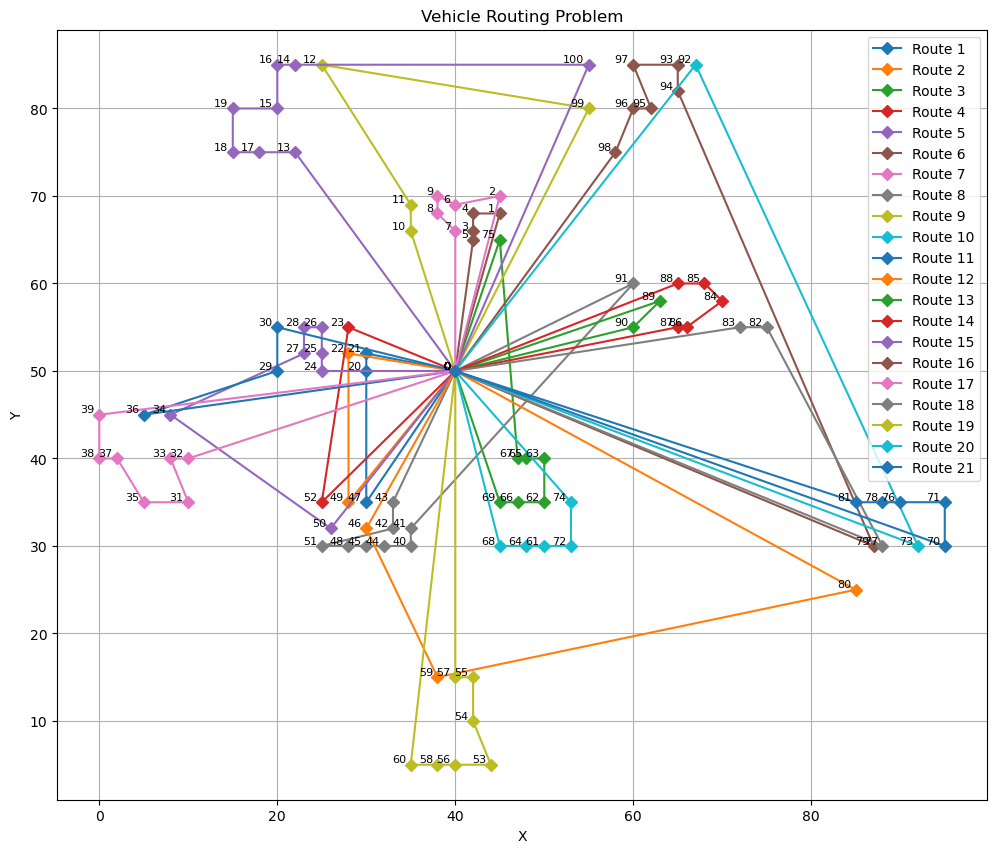

In [43]:
#Use two opt
def two_opt(routes, adj_matrix, num_iterations):
    best_routes = routes.copy()

    for _ in range(num_iterations):
        selected_route_index = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_index]

        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1: i - 1: -1]  # Reverse the path between i and j

        new_routes = routes.copy()
        new_routes[selected_route_index] = new_route

        if calculate_total_distance(new_routes[selected_route_index], adj_matrix) < calculate_total_distance(
                best_routes[selected_route_index], adj_matrix
        ):
            best_routes = new_routes

    return best_routes

def vrp_solver2(location, num_iterations):
    """
    Solve the VRP using the provided location for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    nb_vehicle, capacity_max, coordinates, demand, earliest_time, latest_time, service_time  = read_txt_file(location)
    adj_matrix = adjacency_matrix(coordinates)
    all_routes, capacity_list, route_times = nearest_neighbor_with_time_windows(adj_matrix, demand, int(capacity_max), earliest_time, latest_time, service_time)
    route_distances = [calculate_total_distance(route, adj_matrix) for route in all_routes]

    for i in range(len(all_routes)):
        route = all_routes[i]
        optimized_route = two_opt([route], adj_matrix, num_iterations)[0]
        all_routes[i] = optimized_route

    formatted_routes = format_output(all_routes)
    return formatted_routes, route_distances, capacity_list, route_times, coordinates

num_iterations = 100000
solution, route_distances, capacity_list, route_times, coordinates = vrp_solver2(location, num_iterations)

n = 0
for route, distance, route_time in zip(solution, route_distances, route_times):
    print(f"Route {n+1}: {route}\nTruck capacity: {capacity_list[n]}\n"
          f"Total distance travelled: {distance}\n"
          f"Total time: {route_time}\n")
    n += 1
    
plot_routes_with_coordinates(coordinates, solution)